Created by Henry S with help from Nikolas Hadjiantoni and Guy Davies to fit a Gaussian process to generated gyrochronology data. <br>
We are predicting values of rotational period given the BV and age. 

Some resources used to make this: <br>
https://docs.pymc.io/notebooks/GP-Marginal.html<br>
https://github.com/fonnesbeck/gp_regression <br>

To look into: <br>
https://docs.pymc.io/notebooks/posterior_predictive.html

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib  import cm


import numpy as np
import pymc3 as pm

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#!pip install pymc3 --upgrade  # This must be called every first run

In [3]:
##### OPTIONS #####

map = 1       # 1 - use find map, 0 - sample 
samples = 500  #if sampling, this is the number that decides the sampling and tuning
tune = 1000

errorbars = 0   # plot error bars on surface plot 
smp_rt = 1      # every nth point of true data
num_gen = 100   # given n will produce n x n points of predictions




data = np.genfromtxt('/content/drive/My Drive/data/gyro_fake_data_v1.csv', delimiter=',', skip_header=1)


From Barners 2007,

rotation: P <br>
Age: t<br>
Colur: B-V<br>

$p = f(B-V)g(t)$

$f(B-V) = (0.7725 \pm 0.011) \cdot (B-V - 0.4)^{0.601 \pm 0.024}$

$g(t) = t ^{0.5189 \pm 0.0070}$





In [4]:

X1 = data[:, 1][0::smp_rt]  # age
X2 = data[:, 2][0::smp_rt]  # B-V 
ydata = data[:, 3][0::smp_rt]   # rotation
# Using age and B-V (temperature) to predict rotation

Xs = np.array([X1, X2]).T

bv_offset = 0.4

with pm.Model() as model:

    #### Variable values ####
    g_pow = pm.Normal('g_pow', mu=0.5189, sigma=0.007)
    bv0 = pm.Normal('bv0', mu=0.7725, sigma=0.011)
    f_pow = pm.Normal('f_pow', mu=0.601, sigma=0.024 )

    ##### Offset Values #####
    g0 = pm.Uniform('g0', lower=1, upper=100)
    #####  Set  Values  #####

    #g_pow = 0.52
    #bv0 = 0.77
    #f_pow = 0.60


    g = g0* X1**(g_pow)
    f = bv0 * (X2 - bv_offset)**f_pow
    #from Barnes, 2007.
    resid = ydata - (f * g)
    # Using GP to predict the residuals of the difference between the mean function and data
    # Saves writing a complicated mean function in Theano

    #l1 = pm.Normal('l1', mu=11, sigma=11)  # 1
   # l2 = pm.Normal('l2', mu=0.5, sigma=0.5)  #0.2

    l1 = pm.Normal('l1', mu=160, sigma=30)  # 1
    l2 = pm.Normal('l2', mu=50, sigma=50)  #0.2


    l = [l1, l2]

    sf2 = pm.Normal("sf2", mu=150, sigma=50)
    sn2 = pm.HalfCauchy("sn2", beta=3)

    K = pm.gp.cov.ExpQuad(2, l) * sf2**2
    
    gp = pm.gp.Marginal(cov_func=K)
    obs = gp.marginal_likelihood("obs", X=Xs, y=resid, noise=sn2)

    if map:
        mp = pm.find_MAP()



WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


In [5]:
if not map:
  with model:
    mp = pm.sample(samples, tune=tune, cores=1)



In [6]:
if not map:
  with model: 
    print(pm.summary(mp).round(2))
    
else:
  print(mp)

{'g_pow': array(0.51730642), 'bv0': array(0.77250211), 'f_pow': array(0.60602985), 'g0_interval__': array(-0.60453119), 'l1': array(159.99993963), 'l2': array(49.99961998), 'sf2': array(150.00011452), 'sn2_log__': array(-0.00648031), 'g0': array(35.97746363), 'sn2': array(0.99354064)}


These are the paramters defined by Barnes 2007. <br>
g_pow = $0.5189 +/- 0.0070$ <br>
bvo = $0.7725 \pm 0.011$ <br>
f_pow = $0.601 \pm 0.024$

In [7]:
Xnew1 = np.linspace(np.amin(X1), np.amax(X1), num_gen)
Xnew2 = np.linspace(np.amin(X2), np.amax(X2), num_gen)

Xnew1, Xnew2 = np.meshgrid(Xnew1, Xnew2)

Xnew = np.stack((Xnew1, Xnew2)).T
Xnew_pred = Xnew.reshape(num_gen**2, 2)

# grid of points of to make predictions of rotation at 

In [8]:
mu, var = gp.predict(Xnew_pred, point=mp, diag=True, pred_noise=True)
sd = np.sqrt(var)

mu = mu.reshape(num_gen, num_gen).T

sd = sd.reshape(num_gen, num_gen).T  #do I need to .T here? 
  ## maybe not but it doesnt work if I dont B^)



WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


No handles with labels found to put in legend.


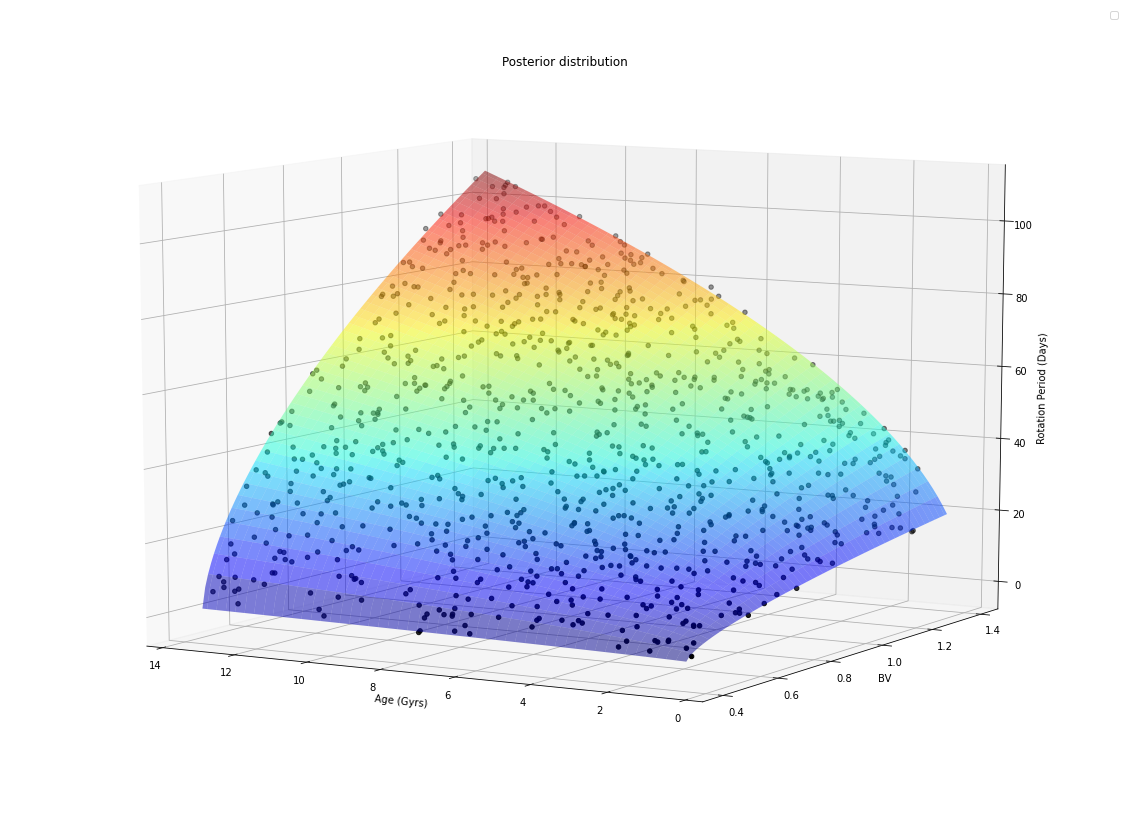

In [9]:

fig = plt.figure(figsize=(20,15))
ax1 = fig.add_subplot(111, projection='3d')


g = mp['g0']*Xnew1**(mp['g_pow'])
f = mp['bv0'] * (Xnew2 - bv_offset)**(mp['f_pow'])
mean = f * g


if errorbars:
  for j in range(len(Xnew1)):
    for i in range(len(Xnew1)):
      plt.plot([Xnew1[i, j], Xnew1[i, j]], [Xnew2[i, j], Xnew2[i, j]], [mu[i, j] + sd[i, j], mu[i, j] - sd[i, j]], marker="_")

ax1.plot_surface(Xnew1, Xnew2,  mean +mu , alpha=0.5, cmap=cm.jet, linewidth=0.1)

ax1.set_xlabel("Age (Gyrs)")
ax1.set_ylabel("BV")
ax1.set_zlabel('Rotation Period (Days)')


ax1.scatter(X1, X2, ydata, color='k')



# axis labels and title

plt.title("Posterior distribution")
plt.legend()
ax1.view_init(10, 300)
ax1.invert_yaxis()
plt.show()





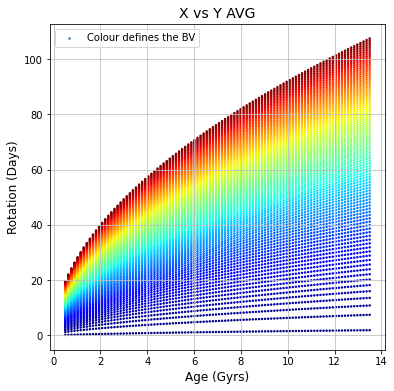

In [10]:



fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_title("X vs Y AVG", fontsize=14)
ax.set_xlabel("Age (Gyrs)", fontsize=12)
ax.set_ylabel("Rotation (Days)", fontsize=12)
ax.grid(True, linestyle='-', color='0.75')



# scatter with colormap mapping to z value
ax.scatter(Xnew1 ,mean+mu, s=2, c=Xnew2, marker = 'o', cmap = cm.jet, label='Colour defines the BV')
 ### Do I want mu or mu - mean here? 
plt.legend()
plt.show()




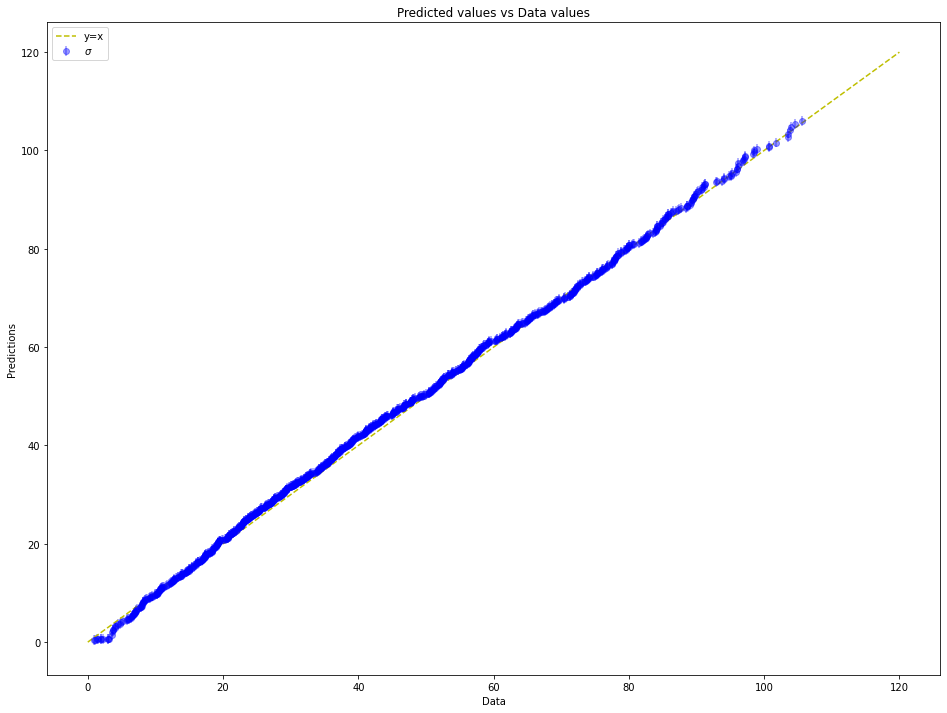

In [11]:
numElems = len(ydata)
idx = np.round(np.linspace(0, len(mu.reshape(num_gen**2)) - 1, numElems)).astype(int)
# Picks equal spaced elements from (longer) prediction array so that its shape of data


y_pred = mean - mu
mu_test = (y_pred.reshape(num_gen**2)[idx])
sd_test = (sd.reshape(num_gen**2)[idx]) 

vals = np.sort([mu_test, sd_test], axis=1)
# sorts them together :) 

fig = plt.figure(figsize=(16, 12))

plt.plot([0, 120], [0, 120], linestyle='--', label='y=x', color='y')
plt.errorbar(np.sort(ydata), vals[0, :], yerr=vals[1, :], fmt='o', label=r'$\sigma$', color='b', alpha=0.4)


plt.xlabel("Data")
plt.ylabel("Predictions")
plt.title("Predicted values vs Data values")
plt.legend()


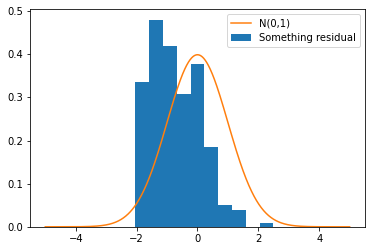

In [12]:
Z = (np.sort(ydata) - vals[0, :])/(vals[1, :])**2


x = np.linspace(-5,5, 1000)
f = 1/np.sqrt(2 * np.pi) * np.exp(-1/2 * x**2) #N(0,1) to compare with Z 

plt.hist(Z, density=True, label='Something residual')
 
plt.plot(x,f, label='N(0,1)')
plt.legend()



In [13]:
# Some arbitaryish measure of badness 

print('Badness 1: ', np.mean(np.sort(ydata)- vals[0, :]))

print('Badness 2: ',  np.abs(Z).mean())

Badness 1:  -0.7137499563961355
Badness 2:  0.9123219063010531
